In [1]:
# A faster more concise version of Rift_retrieval 
# less interactive for cranking out calculationsa

In [1]:
#Sort in order of appearance

import numpy as np
import sys
import logging
import concurrent.futures
import configparser
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json
import utils.toolshelf as t
from random import sample
import os
from ipyleaflet import Map, WMSLayer, basemaps, GeoData, projections
import cartopy.crs as ccrs
import cartopy as c
from cartopy.io import img_tiles

import fiona


import os
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray
import rasterio as rs
from rasterio import plot, mask
import rioxarray

from shapely import Polygon

import geopandas as gpd
import pandas as pd
#warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#### Choose .ini file

ini = 'config/shackleton_s1_test.ini'

###

In [3]:
####################### LOAD PARAMETERS #################

In [4]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the configuration file
config.read(ini)

# Access parameters
shelf = config.get('track', 'shelf')
site = config.get('track', 'site')
cycle = config.get('track', 'cycle')

accessType03 = config.getint('access', 'accessType03')
accessType06 = config.getint('access', 'accessType06')

res = config.getfloat('resolution', 'res')
cnf = config.getint('resolution', 'cnf')
minLength = config.getint('resolution', 'minLength')

plot03Flag = config.getint('plotting', 'plot03Flag')
plotImgFlag = config.getint('plotting', 'plotImgFlag')

sFlag06 = config.getint('output', 'sFlag06')
sFlagm = config.getint('output', 'sFlagm')
sFlag03 = config.getint('output', 'sFlag03')

datRoot = config.get('output', 'datRoot')

# Save outside of file to prevent overwriting of good data
file03_save= f"{datRoot}/{shelf}/{site}/{shelf}_{site}_ATL03_{cycle}_{int(res)}m"
file06_save= f"{datRoot}/{shelf}/{site}/{shelf}_{site}_ATL06_{cycle}_{int(res)}m"
fileMel_save= f"{datRoot}/{shelf}/{site}/{shelf}_{site}_ATL06_{cycle}_{int(res)}m_mel"

file03_load= f"{datRoot}/{shelf}/{site}/is2_{int(res)}m/{shelf}_{site}_ATL03_{cycle}_{int(res)}m"
file06_load= f"{datRoot}/{shelf}/{site}/is2_{int(res)}m/{shelf}_{site}_ATL06_{cycle}_{int(res)}m"
fileMel_load= f"{datRoot}/{shelf}/{site}/is2_{int(res)}m/{shelf}_{site}_ATL06_{cycle}_{int(res)}m_mel"

# Print parameters for verification
print("site:", site)
print("shelf:", shelf)
print("cycle:", cycle)
print("accessType03:", accessType03)
print("accessType06:", accessType06)
print("res:", res)
print("cnf:", cnf)
print("minLength:", minLength)
print("plot03Flag:", plot03Flag)
print("plotImgFlag:", plotImgFlag)
print("sFlag06:", sFlag06)
print("sFlagm:", sFlagm)
print("sFlag03:", sFlag03)
print("datRoot:", datRoot)
print("file03_save:", file03_save)
print("file06_save:", file06_save)
print("fileMel_save:", fileMel_save)
print("file03_load:", file03_load)
print("file06_load:", file06_load)
print("fileMel_load:", fileMel_load)


site: s1_test
shelf: shackleton
cycle: 20
accessType03: 0
accessType06: 1
res: 10.0
cnf: 0
minLength: 100
plot03Flag: 0
plotImgFlag: 0
sFlag06: 1
sFlagm: 0
sFlag03: 0
datRoot: ../data
file03_save: ../data/shackleton/s1_test/shackleton_s1_test_ATL03_20_10m
file06_save: ../data/shackleton/s1_test/shackleton_s1_test_ATL06_20_10m
fileMel_save: ../data/shackleton/s1_test/shackleton_s1_test_ATL06_20_10m_mel
file03_load: ../data/shackleton/s1_test/is2_10m/shackleton_s1_test_ATL03_20_10m
file06_load: ../data/shackleton/s1_test/is2_10m/shackleton_s1_test_ATL06_20_10m
fileMel_load: ../data/shackleton/s1_test/is2_10m/shackleton_s1_test_ATL06_20_10m_mel


In [5]:
########################### BEGIN ####################

In [6]:
# Configure ICESat-2 API
try: icesat2.init("slideruleearth.io", verbose=True)
except: print()

#Params
parms = {
    "poly": t.getRegion(shelf, site, cycle),
    "srt": 0,
    "len": res*2,
    "res": res,
    "cnf": cnf,
    "maxi": 6,
    "ats": 5.0,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": cycle,
    "atl03_geo_fields": ['geoid', 'dem_h', 'dem_flag', 'tide_earth', 'tide_ocean', 'geoid_free2mean', 'tide_earth_free2mean']
}

In [7]:
%%time

atl06_sr = t.get06Data(parms, file06_load=file06_load, accessType=accessType06, file06_save=file06_save, sFlag06=sFlag06, verbose=False)

# separate all good tracks and put them into a list
trackList = t.getTrackList(atl06_sr, return_lens=False, omit=None, verbose=True, min_photons=minLength)
ss_atl06_sr = pd.concat([t.getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])

#Geoid and Tides
ss_atl06_sr.h_mean -= ss_atl06_sr.geoid+ss_atl06_sr.tide_earth+ss_atl06_sr.tide_ocean

# Establish mélange cutoff from mean
melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<ss_atl06_sr.h_mean.mean()]

#print lengths for plotting limits
melange_trackList, lens = t.getTrackList(melange_sr, return_lens=True, verbose=False, min_photons=0)

#new tracklist (dont think I need this)
#ss_atl06_sr_list = [(t.getTrack(atl06_sr, trackInfo)[1:]) for trackInfo in trackList]

t.display06Info(ss_atl06_sr)


if sFlagm==1: t.toGeojson(melange_sr, fileMel_save)

file not found: ../data/shackleton/s1_test/is2_10m/shackleton_s1_test_ATL06_20_10m
processing fresh
Processing new ATL06-SR dataset...     DONE
Saving to ../data/shackleton/s1_test/shackleton_s1_test_ATL06_20_10m.geojson...     DONE
Finding tracks with minimum of 100 photons
7 found with lengths [1415, 1433, 1435, 577, 1379, 1331, 1273]
*********************************************************
Reference Ground Tracks: [  34  240 1185]
Beams: ['gt1r', 'gt2r', 'gt3r']
Cycles: [20]
Received 8843 elevations
Across 7 strong tracks
Date range 2023-06-22 to 2023-09-05
Vertical range -3.4028234663852912e+38m to 136.87089016468596m
*********************************************************
CPU times: user 5.72 s, sys: 211 ms, total: 5.94 s
Wall time: 12.6 s


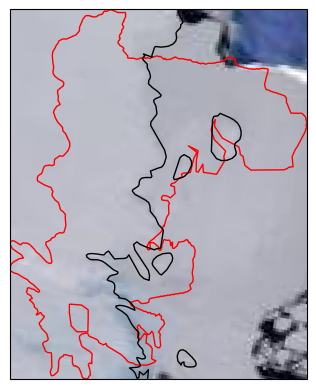

In [10]:
# Vew polygon and tracks to check that it all looks good
resolution = '10m'

shelfPath = f"../shapes/shackleton/shackleton_00.geojson"
shpPath = f"../shapes/{shelf}/{shelf}_{site}_{cycle}.geojson"
if not os.path.isfile(shpPath): shpPath = f"../shapes/{shelf}/{shelf}_{site}_00.geojson"
# Read in EPSG:3031 shapefile and convert to EPSG:4326
shpFile = gpd.read_file(shpPath)
shpFile.crs = 'EPSG:3031'
shpDF = shpFile.to_crs(shpFile.crs)
shelfFile = gpd.read_file(shelfPath)
shelfFile.crs = 'EPSG:3031'
shelfDF = shelfFile.to_crs(shelfFile.crs)
#region = sliderule.toregion(shpDF)["poly"]

# Step 2: Load Antarctic Basemap
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
#bbox = shelfDF.to_crs('EPSG:4326').total_bounds
bbox = shelfDF.total_bounds
ax.set_extent([bbox[0], bbox[2], bbox[1], bbox[3]], crs=ccrs.SouthPolarStereo())
#ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution=resolution)

ax.add_feature(c.feature.OCEAN, facecolor='lightblue')

tiler = img_tiles.GoogleTiles(style='satellite')
ax.add_image(tiler, 5)

# Step 3: Plot the Polygon
# Replace 'your_polygon_file.shp' with your actual polygon file

# Assuming your polygon is already in EPSG:3031, if not, you may need to reproject it.
# polygon_data = polygon_data.to_crs(epsg=3031)

shelfDF.plot(ax=ax, facecolor='none', edgecolor='red')
shpDF.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()


In [ ]:
# Plot method (0: random track, 1: everything)
plotMethod = 1
savePlot = False

# plot settings
yl = None#[0, 92]
xl=None
xBuffer = 0.3
yBuffer=0.1

#################################
# Plotting function
longestMel = t.getTrack(melange_sr, trackList[lens.index(max(lens))])[0]
pltWidth = (longestMel.geometry.y.max()-longestMel.geometry.y.min())*(1.0+xBuffer)
pltBuffer = (ss_atl06_sr.h_mean.max()-ss_atl06_sr.h_mean.min())*(yBuffer)
yl = [np.percentile(ss_atl06_sr.h_mean, 0.1)-pltBuffer, np.percentile(ss_atl06_sr.h_mean, 99.9)+pltBuffer]

def plot06(trackData, save=False, point='-', titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xBuffer=0.3, yl=None, xvar='lat'):
    track, mTrack, cycle, rgt, gt, dat = trackData[0], trackData[1], trackData[2], trackData[3], trackData[4], trackData[5]
    
    #plot the track
    fig, ax = plt.subplots(figsize=[10, 3])

    if xvar=='lat': x = track.geometry.y
    elif xvar=='dist': x = (track['distance']-track['distance'][0])/1000
    y = track.h_mean
    ax.plot(x, y, '-', color='orange', linewidth=2, label='ATL06-SR')
    ax.plot(x, y, point, color='black', linewidth=2.5)#, label='ATL06-SR')

    if xvar=='lat': x = mTrack.geometry.y
    elif xvar=='dist': x = (mTrack['distance']-mTrack['distance'][0])/1000
    y = mTrack.h_mean
    ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
    ax.set_title(titl)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    avg = np.mean(track.h_mean)
    ax.set_ylim(yl)
    
    # set window
    # if there is melange, center it
    # otherwise center the entire track
    try: 
        med = np.median(mTrack.geometry.y)
        mMax = mTrack.geometry.y.max()
        mMin = mTrack.geometry.y.min()
        buffer = np.abs(mMax - mMin)*xBuffer
        #ax.set_xlim([med-pltWidth/2, med+pltWidth/2])
    except:
        #print('doing the other one')
        med = np.median(track.geometry.y)
        tMax = track.geometry.y.max()
        tMin = track.geometry.y.min()
        buffer = np.abs(tMax - tMin)*xBuffer
        #ax.set_xlim([tMin-buffer, tMax+buffer])
    ax.legend(loc=4, frameon=False)
    info = f'ICESat-2 track {rgt}-{t.gtDict[gt]}'
    plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
             transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
    if save:
        plt.savefig(f'{figRoot}melange/{site}_cyc{cycle}_rgt{rgt}-{t.gtDict[gt][-2:]}_res{res}_mel.png', 
                    dpi=150, bbox_inches='tight')
    
###################################    
#Plotting commands

if plotMethod==0:
    tr = sample(trackList, 1)[0]
    track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, tr)
    mTrack, cycle, rgt, gt = t.getTrack(melange_sr, tr)
    dat = track.index.min().date()
    
    trackData = [track, mTrack, cycle, rgt, gt, dat]
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    plot06(trackData, point='.', save=savePlot, titl=titl, xlab=xlab, ylab=ylab, yl=yl, xBuffer=0.3)
    
elif plotMethod==1:
    count=0
    
    for tr in trackList:
        print(f"{count}, {tr}")
        count+=1
        
        track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, tr)
        mTrack, cycle, rgt, gt = t.getTrack(melange_sr, tr)
        dat = track.index.min().date()
        
        trackData = [track, mTrack, cycle, rgt, gt, dat]
        titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
        xlab = 'S-N latitude'
        ylab = 'Elevation above geoid (m)'
        plot06(trackData, point='.', save=savePlot, titl=titl, xlab=xlab, ylab=ylab, yl=yl, xBuffer=0.3)
        #plt.axhline(y=60)

In [204]:
'''
goodTracks = []
allTracks = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
elevMin = -5
elevMax = 100
for tr in allTracks:
    tr.h_mean -= geoidDefault
    if (tr.h_mean.max() < elevMax) and (tr.h_mean.min() > elevMin):
        #print(f'{tr.h_mean.max()}, {tr.h_mean.min()}')
        goodTracks.append(tr)
ss_atl06_sr = pd.concat(goodTracks)
'''

"\ngoodTracks = []\nallTracks = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]\nelevMin = -5\nelevMax = 100\nfor tr in allTracks:\n    tr.h_mean -= geoidDefault\n    if (tr.h_mean.max() < elevMax) and (tr.h_mean.min() > elevMin):\n        #print(f'{tr.h_mean.max()}, {tr.h_mean.min()}')\n        goodTracks.append(tr)\nss_atl06_sr = pd.concat(goodTracks)\n"

In [51]:
# Filter tracks
#track choice method (0: drop photons (not valid technique), 1: drop whole tracks)
trackMethod = 1

if trackMethod==0:
    # separate all good tracks and put them into a list
    trackList = t.getTrackList(atl06_sr, min_photons=0, print_lens=False)
    ss_atl06_sr = pd.concat([getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])

    #Geoid and outliers
    # for ross limits good limits are
    print('correcting for geoid, scraping outliers')
    ss_atl06_sr.h_mean -= geoidDefault
    ss_atl06_sr = ss_atl06_sr[(ss_atl06_sr.h_mean<100)*(ss_atl06_sr.h_mean>-5)]

    melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
    ss_atl06_sr_list = [t.getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
    displayInfo(ss_atl06_sr)
    saveMelange(melange_sr)
    
if trackMethod==1:
    
    trackList = t.getTrackList(atl06_sr, min_photons=0, return_lens=False)
    
    goodTracks = []
    goodMel = []
    allTracks = [t.getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
    #Ross
    elevMin = -5
    elevMax = 100
    melMinPoints = 100
    #filchner 
    elevMin = -2
    elevMax = 100
    melMinPoints = 100
    for tr in allTracks:
        tr.h_mean -= geoidDefault
        if (tr.h_mean.max() < elevMax) and (tr.h_mean.min() > elevMin):
            #print(f'{tr.h_mean.max()}, {tr.h_mean.min()}')
            mel = tr[tr.h_mean<melangeCutoffDict[site]]
            if len(mel) > melMinPoints: 
                goodMel.append(mel)
                goodTracks.append(tr)
            
    ss_atl06_sr = pd.concat(goodTracks)
    melange_sr = pd.concat(goodMel)
    
    #melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
    ss_atl06_sr_list = [t.getTrack(ss_atl06_sr, trackInfo)[0] for trackInfo in trackList]
    displayInfo(ss_atl06_sr)
    goodTrackList = t.getTrackList(ss_atl06_sr, return_lens=False)
    saveMelange(melange_sr)

NameError: name 'geoidDefault' is not defined

Finding tracks with minimum of 200 photons
35 found
Reference Ground Tracks: [ 109  231  253  314  375  612  673 1054 1115 1176 1198]
Beams: ['gt2l', 'gt1l', 'gt3l']
Cycles: [5]
Received 13007 elevations
Across 36 strong tracks
Date range 2019-10-04 to 2019-12-14
Vertical range 11.810047838175246m to 90.96356051308204m
Finding tracks with minimum of 200 photons
35 found

In [102]:
shpPath = f"../shapes/{shelf}/{shelf}_{site}_{cycle}.geojson"
if not os.path.isfile(shpPath): shpPath = f"../shapes/{shelf}/{shelf}_{site}_00.geojson"
# Read in EPSG:3031 shapefile and convert to EPSG:4326
shpFile = gpd.read_file(shpPath)
shpFile.crs = 'EPSG:3031'
target_epsg = 'EPSG:4326'
shpDF = shpFile.to_crs(target_epsg)
region = sliderule.toregion(shpDF)["poly"]

In [107]:
shpDF.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [95]:
antarctica_polygon = Polygon([(-180, -90), (180, -90), (180, -60), (-180, -60)])
antarctica_gdf = gpd.GeoDataFrame(geometry=[antarctica_polygon])

In [96]:
antarctica_gdf

,geometry
0,"POLYGON ((-180.00000 -90.00000, 180.00000 -90...."


In [ ]:
# Define a custom Antarctic projection
antarctic_projection = CRS(
    code='EPSG:3031',
    proj4def='+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',
    resolutions=[8192, 4096, 2048, 1024, 512, 256, 128],
    origin=[-20037508.34, -20037508.34]
)

# Create a GeoDataFrame with a single polygon covering Antarctica
antarctica_polygon = Polygon([(-180, -90), (180, -90), (180, -60), (-180, -60)])
antarctica_gdf = gpd.GeoDataFrame(geometry=[antarctica_polygon])

# Convert the polygon to the custom Antarctic projection
antarctica_gdf = antarctica_gdf.to_crs(epsg=3031)

# Create a map with the custom Antarctic projection
m = Map(center=(-90, 0), zoom=2, crs=antarctic_projection)

# Create a GeoData layer for the polygon
geo_data = GeoData(geo_dataframe=antarctica_gdf, style={'color': 'blue', 'fillColor': 'blue', 'opacity':0.4})

# Add the GeoData layer to the map
m.add_layer(geo_data)

# Display the map
m

In [93]:
projection = 'South'
max_plot_points = atl06_sr.shape[0]
cpoint = atl06_sr.iloc[100].geometry
m = ipyleaflet.Map(crs=projections.Simple, center=[cpoint.x, cpoint.y], zoom = 3, scroll_wheel_zoom=True)
#m = ipysliderule.leaflet(projection, center=[cpoint.x, cpoint.y], zoom=10, scroll_wheel_zoom=True)
#geo_data = ipyleaflet.GeoData(geo_dataframe = ss_atl06_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
#m.add(geo_data)
m

Map(center=[99.78130120353904, -66.20642534934316], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [85]:
# create map with NASA Blue Marble as background
m = Map(center=(-90, 0), zoom=1, crs=projections.EPSG3031)

# projection for Polarview sea ice edge
POLAR3031 = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds=[[-2822131.5,-3057369.25],[3744213.75,3822194.25]]
)
wms = WMSLayer(
    url='http://geos.polarview.aq/geoserver/wms',
    layers='polarview:iceedgeS15',
    format='image/png',
    transparent=True,
    attribution='Polarview',
    crs=POLAR3031
)
m.add(wms)
m


Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [11]:
# Plot every 40 points from tracklist to not slow down the notebook
projection = 'South'
max_plot_points = atl06_sr.shape[0]
cpoint = atl06_sr.iloc[1000].geometry
m = ipysliderule.leaflet(projection, center=[cpoint.x, cpoint.y], zoom=10, scroll_wheel_zoom=True)
m.GeoData(ss_atl06_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
display.display(m.map)

Deprecated. Will be removed in a future release
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/ccroberts/opt/anaconda3/envs/fresh/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Map(center=[99.77317073283398, -66.23535219044068], controls=(ZoomControl(options=['position', 'zoom_in_text',…

0, (16, 34, 'gt1l')
1, (16, 34, 'gt2l')
2, (16, 34, 'gt3l')
3, (16, 240, 'gt1l')
4, (16, 476, 'gt2l')
5, (16, 476, 'gt3l')
6, (16, 743, 'gt3l')


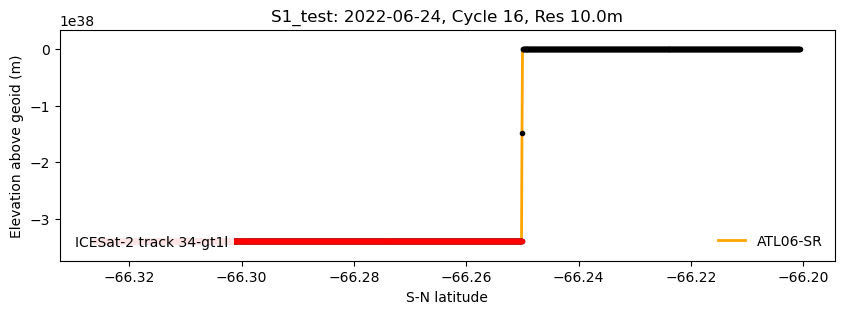

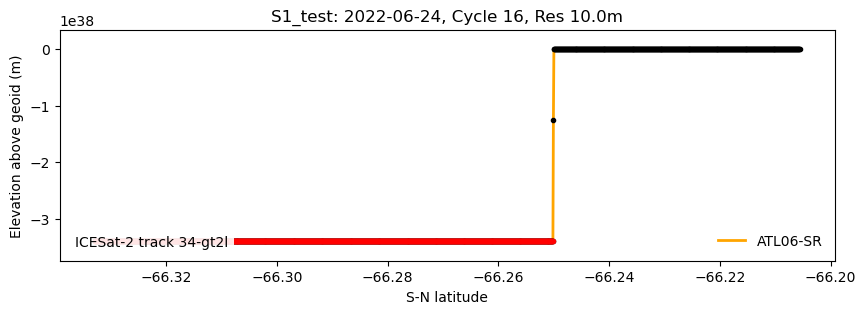

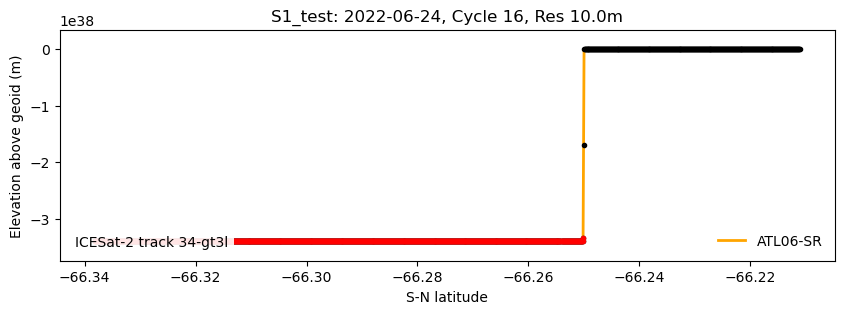

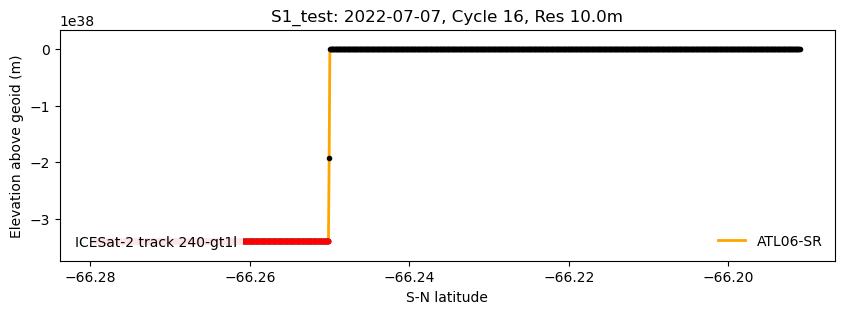

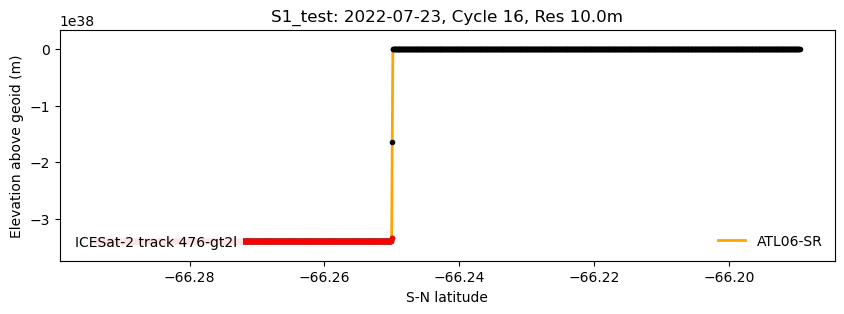

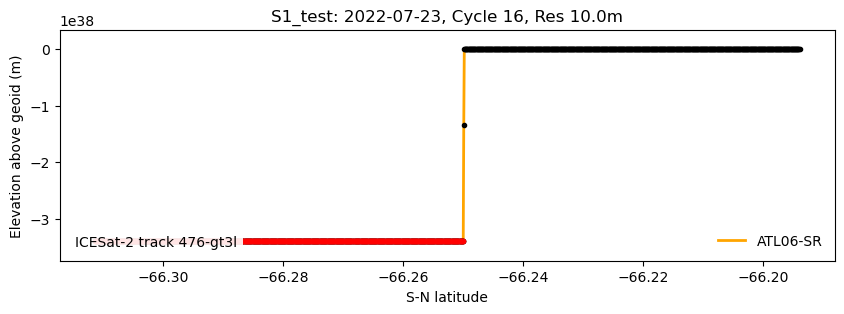

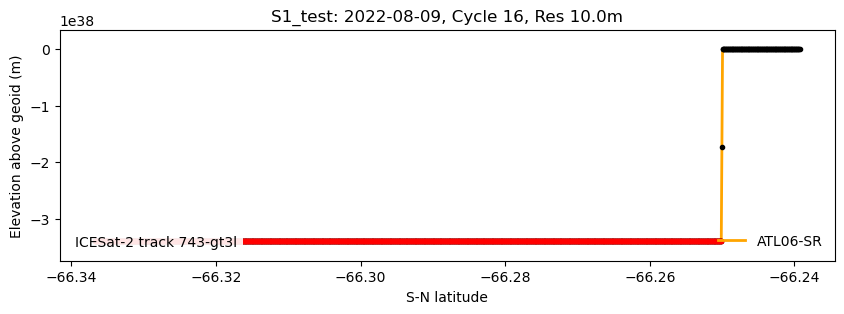

In [16]:
# Plot method (0: random track, 1: everything)
plotMethod = 0
if plotMethod==0:
    trackInfo = sample(trackList, 1)[0]
    track, cycle, rgt, gt = t.getTrack(ss_atl06_sr, trackInfo)
    mTrack, cycle, rgt, gt = t.getTrack(melange_sr, trackInfo)

    try: 
        isSeaward = track.geometry.y.iloc[0]< track.geometry.y.iloc[10]
        dat = track.index.min().date()
        print(f"Randomly selected track: Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {t.gtDict[gt]}")
        print(f"Contains {len(track)} photons")
    except: 
        print(f"Exception: Random track Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {t.gtDict[gt]} does not contain enough data")
        if rgt not in insufficientDataCache: insufficientDataCache.append([rgt, t.gtDict[gt]])
        print(f"Insufficient data cache: {insufficientDataCache}")
        
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    yl = [-8, 60]
    plot06(track, save=False, titl=titl, xlab=xlab, ylab=ylab, yl=yl)
    
elif plotMethod==1:
    count=0
    
    for t in goodTrackList:
        print(f"{count}, {t}")
        print(f"{len(mTrack)}")
        count+=1
        
        track, cycle, rgt, gt = getTrack(ss_atl06_sr, t)
        mTrack, cycle, rgt, gt = getTrack(melange_sr, t)
        
        
        titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
        xlab = 'S-N latitude'
        ylab = 'Elevation above geoid (m)'
        yl = None#[-8, 60]
        yl= [10, 90]
        plot06(track, save=True, titl=titl, xlab=xlab, ylab=ylab, yl=yl)

Randomly selected track: Site s1_test, 2022-07-23, Cycle 16, RGT 476, Beam gt2l
Contains 1179 photons


KeyError: 0